In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import scanpy as sc
import scvi
import matplotlib.pyplot as plt
import scib

Global seed set to 0
During startup - Warning message:
Setting LC_CTYPE failed, using "C" 


# totalVI

## Load the dataset

In [2]:
scrna = sc.read("../../../data/neurips-cite/rna_hvg_batch.h5ad")
scrna

AnnData object with n_obs × n_vars = 90261 × 4000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [3]:
cite = sc.read('../../../data/neurips-cite/protein.h5ad')
cite

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/GEX_n_genes_by_counts' was written without encoding metadata.
  return read_elem(dataset)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/GEX_pct_counts_mt' was written without encoding metadata.
  return read_elem(dataset)
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/GEX_size_factors' was written without encoding metadata.
  return read_elem(dataset)
/lustre/

/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/obsm' was written without encoding metadata.
  d[k] = read_elem(f[k])
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/ADT_X_pca' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/obsm/ADT_X_umap' was written without encoding metadata.
  return {k: read_elem(v) for k, v in elem.items()}
/lustre/groups/ml01/workspace/anastasia.litinetskaya/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obsm/ADT_isotype_controls/Mouse-IgG1' was written without encoding met

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

## Configure and train the model

In [4]:
# scvi needs one adata, so we merge rna and cite
adata = scrna
adata.X = scrna.layers['counts'].A.copy()
adata.obsm['proteins'] = cite.layers['counts'].A.copy()

In [5]:
scvi.model.TOTALVI.setup_anndata(adata, batch_key='batch', protein_expression_obsm_key='proteins')

INFO     Generating sequential column names                                                  


In [6]:
vae = scvi.model.TOTALVI(adata, latent_distribution="normal")

INFO     Computing empirical prior initialization for protein background.                    


In [7]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 89/89: 100%|██████████| 89/89 [09:16<00:00,  6.26s/it, loss=1.39e+03, v_num=1]


In [8]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

## Visualize results

In [9]:
sc.pp.neighbors(adata, use_rep='X_totalVI')
sc.tl.umap(adata)

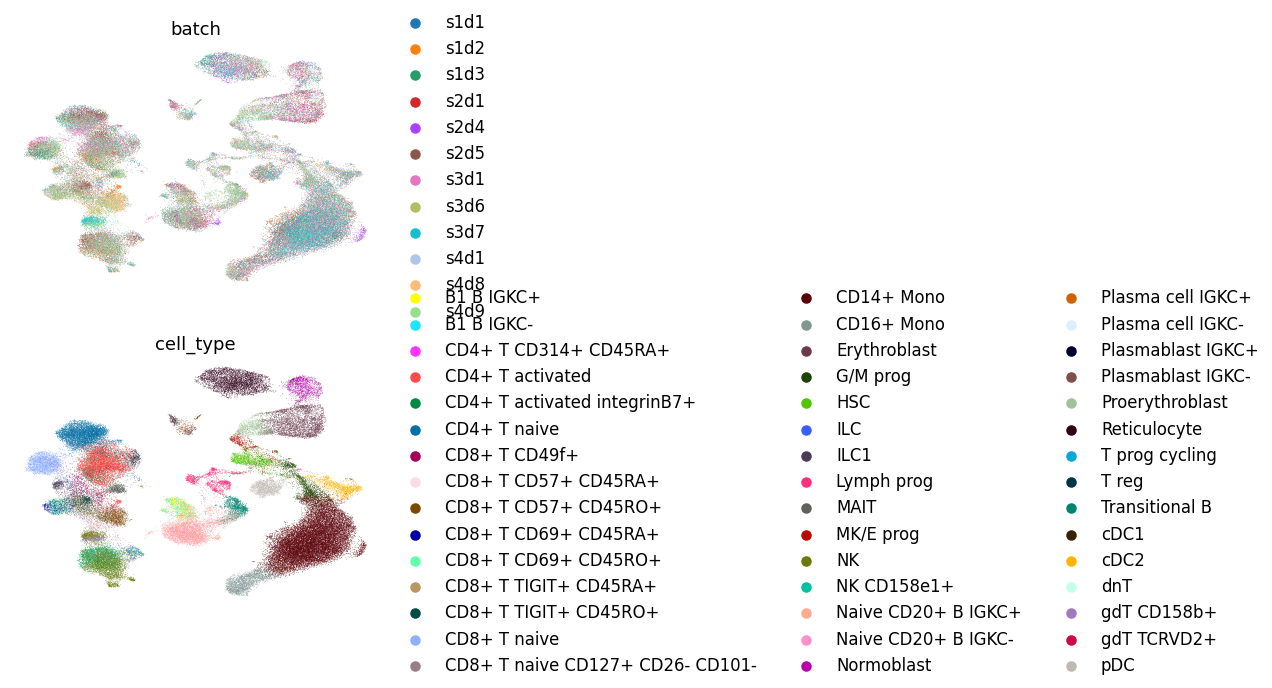

In [10]:
sc.pl.umap(adata, color=['batch', 'cell_type'], ncols=1, frameon=False)

## scIB metrics

In [11]:
scib_anndata = sc.AnnData(adata.obsm['X_totalVI']).copy()
scib_anndata.obs = adata.obs.copy()
scib_anndata.uns['neighbors'] = adata.uns['neighbors'].copy()
scib_anndata.obsp['connectivities'] = adata.obsp['connectivities'].copy()
scib_anndata.obsp['distances'] = adata.obsp['distances'].copy()
scib_anndata.obsm['X_totalVI'] = adata.obsm['X_totalVI'].copy()

In [12]:
scib_anndata.write('neurips-cite-totalvi.h5ad')

In [13]:
metrics = scib.metrics.metrics(
    scib_anndata, 
    scib_anndata, 
    batch_key='batch', 
    label_key='cell_type', 
    embed='X_totalVI',
    ari_=True,
    nmi_=True,
    silhouette_=True,
    graph_conn_=True,
    isolated_labels_asw_=True,
)
metrics

NMI...
ARI...
Silhouette score...
Isolated labels ASW...
Graph connectivity...


,0
NMI_cluster/label,0.795523
ARI_cluster/label,0.770435
ASW_label,0.559358
ASW_label/batch,0.894195
PCR_batch,NaN
cell_cycle_conservation,NaN
isolated_label_F1,NaN
isolated_label_silhouette,0.569714
graph_conn,0.933765
kBET,NaN


In [14]:
metrics.to_csv('neurips_cite_totalvi.csv')